In [1]:
import sys
sys.path.append("../")  

import numpy as np 
import torch, time
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import utility, problem
import random
import net
from scipy.linalg import lstsq
torch.set_default_dtype(torch.float64)

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）

plt.rcParams.update({
    'font.size': 20,
})

# 设置随机种子
set_seed(42)

In [2]:
def trainnew(model,problem,device,params,optimizer,scheduler,bdry_penalty="False"):
    
    problem.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
    int_data = problem.data()["interior_points"]
    bdry_data = problem.data()["boundary_points"]
    int_data.requires_grad = True
    bdry_data.requires_grad = True
    projection_errors = []
    orthogonality_errors_l0 = []
    orthogonality_errors_l1 = []
    ranks = []
    singular_values = [] 
    initialloss = 1
    model.train()
    for step in range(params["trainStep"]):
        u = model(int_data)[1]
        u = u.squeeze(1) if len(u.shape) == 2 else u
        u_second = model(int_data)[0]
        u_bdry = model(bdry_data)[1]
        u_bdry = u_bdry.squeeze(1) if len(u_bdry.shape) == 2 else u_bdry
        model.zero_grad()
        problem.loss_int(u, int_data)
        problem.loss_bdry(u_bdry, bdry_data)
        loss_pde = problem.loss_pde()
        loss_orthogonal = torch.norm(u_second.T @ u_second - torch.eye(params["width"]).to(device).double(), p='fro')
        loss = loss_pde + loss_orthogonal*params["orthogonalpenalty"] 
        
        if step == 1:
            initialloss = loss_pde.detach().cpu().numpy()
            print("Initial pde loss is %s"%(initialloss))
        else:
            if loss_pde.detach().cpu().numpy()/initialloss < params["epsilon"]:
                print("Final pde loss at Step %s is %s"%(step+1,loss_pde.detach().cpu().numpy()))
                break

        if step%params["writeStep"] == 0:
            basis_matrix = u_second
            tem = utility.evaluate_basis_projection_quality_with_sin(basis_matrix, int_data, max_k=10)
            erorr = tem["mean_error"]
            rank = tem["rank"]
            ranks.append(rank)
            projection_errors.append(erorr)
            
            
            U, S, Vh = torch.linalg.svd(u_second)
            singular_values.append(S.detach().cpu().numpy())
            
            
            A = (u_second.T @ u_second- torch.eye(params["dd"]).to(device).double()).detach().cpu().numpy()
            orthogonality_errors_l0.append(np.max(np.abs(A)))
            orthogonality_errors_l1.append(np.mean(np.abs(A)))
         
            print("Loss at Step %s is %s with pde loss %s, orthogonal loss %s, rank of matrix %s and random projection error %s."%(step,loss.detach().cpu().numpy(),loss_pde.detach().cpu().numpy(),loss_orthogonal.detach().cpu().numpy(),rank, erorr))
            
        if step%params["plotStep"] == params["plotStep"]-1:
            tem = lambda x: model(x)[1]
            problem.plot(tem)
            
            x_min, x_max = -1.0, 1.0
            n_grid_points = 500
            x_grid = torch.linspace(x_min, x_max, n_grid_points).reshape(-1, 1).to(device).double()

            top_k = 10  # 要画的主方向个数

            with torch.no_grad():
                u_grid = model(x_grid)[0]  # shape: (n_points, n_basis)

            F = u_grid.cpu().numpy()  # (n_points, n_basis)
            x_grid_np = x_grid.cpu().numpy().flatten()

            # Step 1: SVD
            U_svd, S_svd, Vh_svd = np.linalg.svd(F, full_matrices=False)

            # Step 2: 构造前 top_k 个 PCA basis 函数
            pca_basis = []
            for k in range(top_k):
                v_k = Vh_svd[k, :]              # shape: (n_basis,)
                phi_k = F @ v_k.T               # shape: (n_points,)
                pca_basis.append(phi_k)

            pca_basis = np.stack(pca_basis, axis=0)  # shape: (top_k, n_points)

            # Step 3: 画 basis 函数
            plt.figure(figsize=(10, 6))
            for i in range(top_k):
                plt.plot(x_grid_np, pca_basis[i], label=f"PCA Basis {i+1}")

            plt.title(f"Top {top_k} PCA (SVD) Basis Functions")
            plt.xlabel("x")
            plt.ylabel("Function value")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    print("after least squares")
    (A, rhs) = problem.leastsquareproblem(model, int_data, bdry_data)
    w, residuals, rank, s = lstsq(A, rhs)
    error = A @ w - rhs
    threshold = 1e-3
    effective_s = s[s > threshold]
    effective_rank = (s > threshold).sum()
    print("the error of least square in problem " + str(problem.name)+": ", np.mean(np.abs(error)))
    print("the condition number of matrix A in problem " + str(problem.name)+": ", np.max(effective_s)/np.min(effective_s))
    print("the rank of matrix A in problem " + str(problem.name)+": ", effective_rank)
    perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
    problem.plot(perdict)
    return ranks, projection_errors, singular_values, orthogonality_errors_l0, orthogonality_errors_l1

In [3]:
def u_exact(x):
    return 1/2*x**2 - 1/2

def f(x):
    return -torch.ones(x.shape[0]).to(x.device)

c:\Users\29433\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss at Step 0 is 1.0078100242424024 with pde loss 1.0078100242424024, orthogonal loss 659.1474049647945, rank of matrix 3 and random projection error 0.3154554118870873.
Initial pde loss is 0.9940840629718947
Loss at Step 5 is 0.9382651822676885 with pde loss 0.9382651822676885, orthogonal loss 661.095411071369, rank of matrix 6 and random projection error 8.568174306039957e-06.
Loss at Step 10 is 0.8185684016680199 with pde loss 0.8185684016680199, orthogonal loss 681.5145560231117, rank of matrix 6 and random projection error 4.637330523223598e-07.
Loss at Step 15 is 0.6092473128964165 with pde loss 0.6092473128964165, orthogonal loss 720.381807432717, rank of matrix 8 and random projection error 5.977644400451763e-09.
Loss at Step 20 is 0.3614174059129758 with pde loss 0.3614174059129758, orthogonal loss 793.0355189046993, rank of matrix 8 and random projection error 4.0525179558168e-12.
Loss at Step 25 is 0.2694879849666403 with pde loss 0.2694879849666403, orthogonal loss 884.094

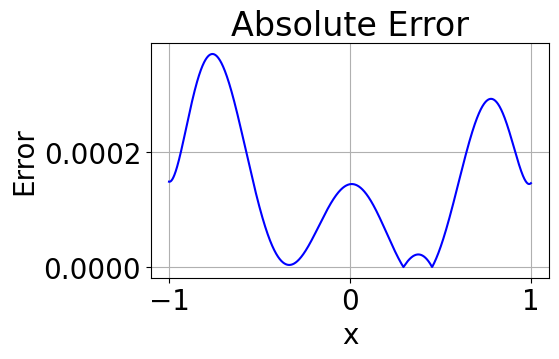

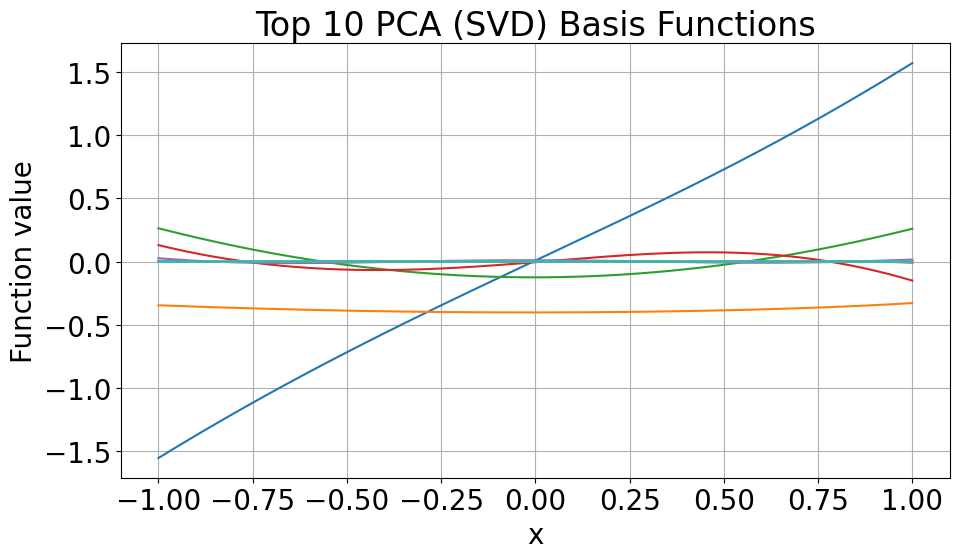

after least squares
the error of least square in problem poisson1d:  1.6241538761503363e-11
the condition number of matrix A in problem poisson1d:  6257810.879509578
the rank of matrix A in problem poisson1d:  16


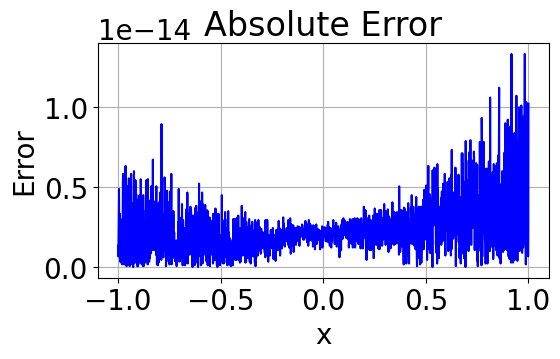

In [4]:
set_seed(42)
Pro = problem.Poisson1D(f, u_exact, u_exact, 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params = {"radius": 1, "d": 1, "bodyBatch": 1024, "bdryBatch": 2, "lr": 0.001, "width": 100, "depth": 2, "trainStep": 200, "bdry_penalty": 1, "numberoftest": 1000, "writeStep": 5, "plotStep": 200, "sampleStep": 25, "step_size": 5000, "milestone": [], "gamma": 0.5, "decay": 0.0001, "lambda": 10, "epsilon": 1e-6, "orthogonalpenalty": 0, "beta": 1}
params["dd"] = params["width"]
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
scheduler = MultiStepLR(optimizer,milestones=params["milestone"],gamma=params["gamma"])

startTime = time.time()
ranks_base, projection_errors_base, singular_values_base, orthogonality_errors_l0_base, orthogonality_errors_l1_base = trainnew(model,Pro,device,params,optimizer,scheduler)  #trainnew model

Loss at Step 0 is 66.92255052072186 with pde loss 1.0078100242424024, orthogonal loss 659.1474049647945, rank of matrix 3 and random projection error 0.3154554118870873.
Initial pde loss is 1.0011521163047168
Loss at Step 5 is 60.463836705595845 with pde loss 0.9706338850703511, orthogonal loss 594.9320282052549, rank of matrix 6 and random projection error 2.3806740872679517e-06.
Loss at Step 10 is 54.655295930167945 with pde loss 0.9197301388690302, orthogonal loss 537.3556579129892, rank of matrix 6 and random projection error 8.726470562896943e-08.
Loss at Step 15 is 49.041412218814074 with pde loss 0.8500490641455102, orthogonal loss 481.9136315466856, rank of matrix 7 and random projection error 1.9619766025554397e-09.
Loss at Step 20 is 43.48169908781648 with pde loss 0.7626692189000774, orthogonal loss 427.19029868916397, rank of matrix 8 and random projection error 3.310691683623773e-11.
Loss at Step 25 is 37.9778402773829 with pde loss 0.6711320401904876, orthogonal loss 373.

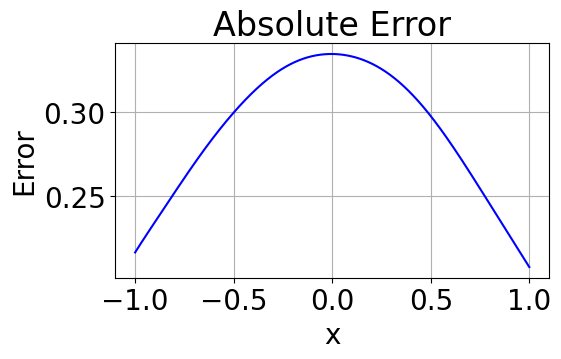

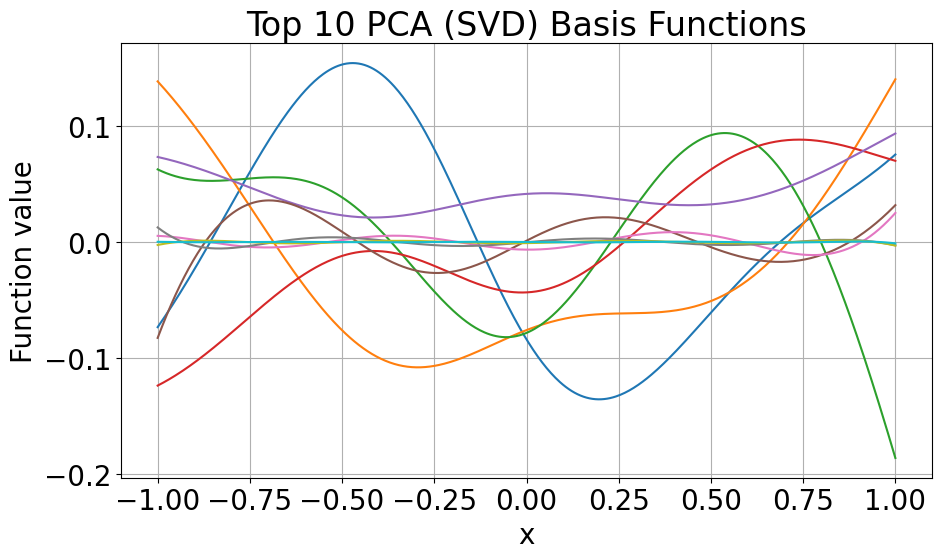

after least squares
the error of least square in problem poisson1d:  3.0670099338706875e-12
the condition number of matrix A in problem poisson1d:  7366097.126848722
the rank of matrix A in problem poisson1d:  22


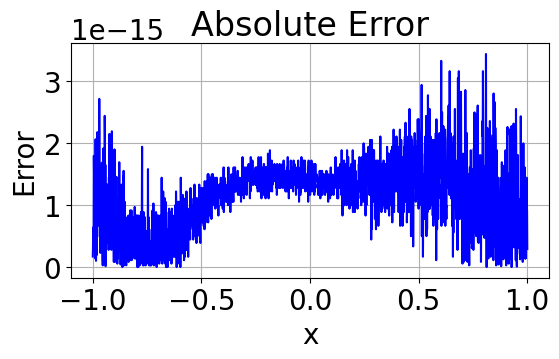

In [5]:
set_seed(42)
Pro = problem.Poisson1D(f, u_exact, u_exact, 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params = {"radius": 1, "d": 1, "bodyBatch": 1024, "bdryBatch": 2, "lr": 0.001, "width": 100, "depth": 2, "trainStep": 200, "bdry_penalty": 1, "numberoftest": 1000, "writeStep": 5, "plotStep": 200, "sampleStep": 25, "step_size": 5000, "milestone": [], "gamma": 0.5, "decay": 0.0001, "lambda": 10, "epsilon": 1e-3, "orthogonalpenalty": 0.1, "beta": 1}
params["dd"] = params["width"]
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
scheduler = MultiStepLR(optimizer,milestones=params["milestone"],gamma=params["gamma"])

startTime = time.time()
ranks_ortho, projection_errors_ortho, singular_values_ortho, orthogonality_errors_l0_ortho, orthogonality_errors_l1_ortho = trainnew(model,Pro,device,params,optimizer,scheduler)  #trainnew model

In [6]:
plt.rcParams.update({
    'font.size': 20
})

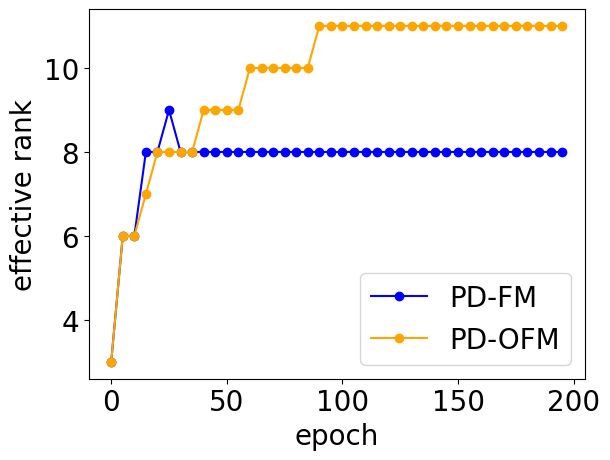

In [7]:
step = np.arange(len(ranks_ortho))*5
plt.plot(step, ranks_base, marker="o",label="PD-FM", color="blue")
plt.plot(step, ranks_ortho, marker="o",label="PD-OFM", color="orange")
plt.xlabel("epoch")
plt.ylabel("effective rank")
plt.legend()
plt.show()

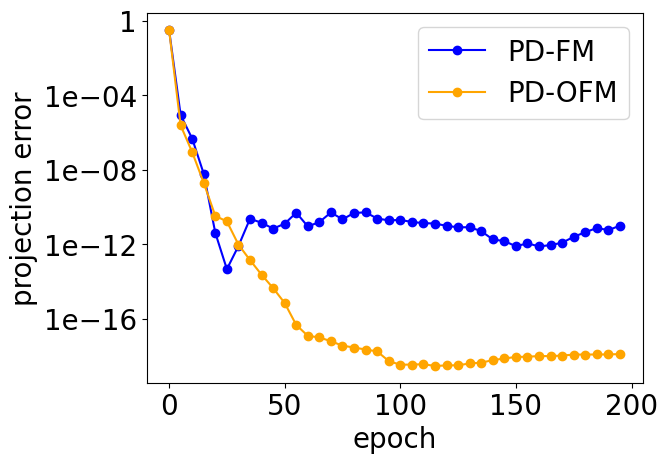

In [8]:
from matplotlib.ticker import LogFormatter
step = np.arange(len(ranks_ortho))*5
plt.plot(step, projection_errors_base, marker="o",label="PD-FM", color="blue")
plt.plot(step, projection_errors_ortho, marker="o",label="PD-OFM", color="orange")
plt.yscale('log')  # 设置对数坐标轴（默认以 10 为底）
plt.gca().yaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=False))

plt.xlabel("epoch")
plt.ylabel("projection error")
plt.legend()
plt.show()

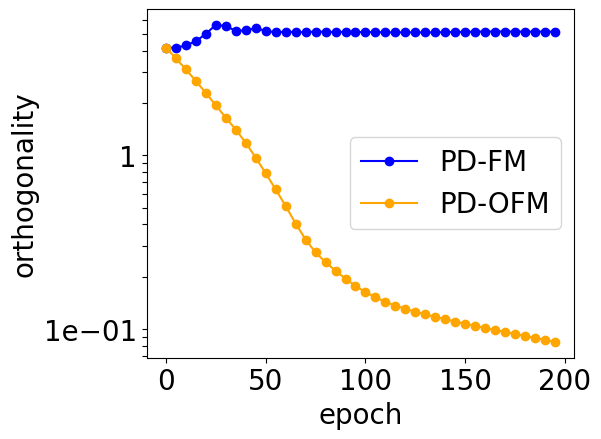

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter

plt.plot(step, orthogonality_errors_l1_base, marker="o", label="PD-FM", color="blue")
plt.plot(step, orthogonality_errors_l1_ortho, marker="o", label="PD-OFM", color="orange")


# 设置对数坐标轴（以10为底）
plt.yscale('log')

# 添加更多纵坐标标签：1,2,3,...,9,10,...
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, subs=range(1, 10), numticks=1000))
plt.gca().yaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=False))

# 打开次刻度线
# plt.minorticks_on()

plt.xlabel("epoch")
plt.ylabel("orthogonality")
plt.legend()
plt.tight_layout()
plt.show()
